# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Jaya Student Performance

- Nama: Daniel Siahaan
- Email: lisnarda.siregar1212@gmail.com
- Id Dicoding: niels11

## Persiapan

### Menyiapkan library yang dibutuhkan
#### 1. Import Library
   Pada tahap ini, kita mengimpor seluruh pustaka yang dibutuhkan dalam pipeline data science, mulai dari eksplorasi data, preprocessing, modeling, evaluasi, visualisasi, hingga penyimpanan model. Library yang digunakan termasuk scikit-learn, XGBoost, CatBoost, seaborn, matplotlib, SHAP untuk interpretasi model, dan imbalanced-learn untuk menangani ketidakseimbangan kelas.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import shap
import pickle
import warnings
warnings.filterwarnings("ignore")

### Menyiapkan data yang akan digunakan

## Data Understanding

**2. Load Dataset**

Dataset yang digunakan berisi informasi akademik dan demografis mahasiswa, dengan target klasifikasi `Status` yang menunjukkan apakah mahasiswa tersebut "Dropout", "Graduate", atau masih "Enrolled". Dataset ini dimuat ke dalam DataFrame dan ditampilkan beberapa baris awal untuk memahami struktur dan tipe data yang tersedia.


In [2]:
# Load dataset
file_path = './data.csv'
df = pd.read_csv(file_path, sep=';')

# Cek struktur data
print(df.shape)
print(df.columns)
print(df.head())


(4424, 37)
Index(['Marital_status', 'Application_mode', 'Application_order', 'Course',
       'Daytime_evening_attendance', 'Previous_qualification',
       'Previous_qualification_grade', 'Nacionality', 'Mothers_qualification',
       'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation',
       'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor',
       'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
       'Age_at_enrollment', 'International',
       'Curricular_units_1st_sem_credited',
       'Curricular_units_1st_sem_enrolled',
       'Curricular_units_1st_sem_evaluations',
       'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade',
       'Curricular_units_1st_sem_without_evaluations',
       'Curricular_units_2nd_sem_credited',
       'Curricular_units_2nd_sem_enrolled',
       'Curricular_units_2nd_sem_evaluations',
       'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade',
       'Curricular_units_

In [3]:
# check missing value
df.isnull().sum()

Marital_status                                  0
Application_mode                                0
Application_order                               0
Course                                          0
Daytime_evening_attendance                      0
Previous_qualification                          0
Previous_qualification_grade                    0
Nacionality                                     0
Mothers_qualification                           0
Fathers_qualification                           0
Mothers_occupation                              0
Fathers_occupation                              0
Admission_grade                                 0
Displaced                                       0
Educational_special_needs                       0
Debtor                                          0
Tuition_fees_up_to_date                         0
Gender                                          0
Scholarship_holder                              0
Age_at_enrollment                               0


**3. Exploratory Data Analysis (EDA)**

Tahap ini bertujuan untuk memahami distribusi data dan pola-pola awal yang mungkin berguna untuk modeling. Beberapa analisis dilakukan:
- Distribusi kelas target `Status` untuk mengetahui imbalance.
- Korelasi antar fitur numerik untuk melihat keterkaitan antar variabel.
- Visualisasi distribusi nilai akademik berdasarkan label `Status` untuk menemukan potensi fitur penting.


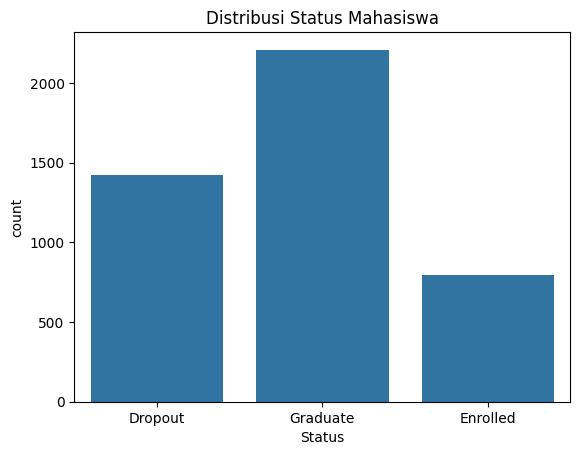

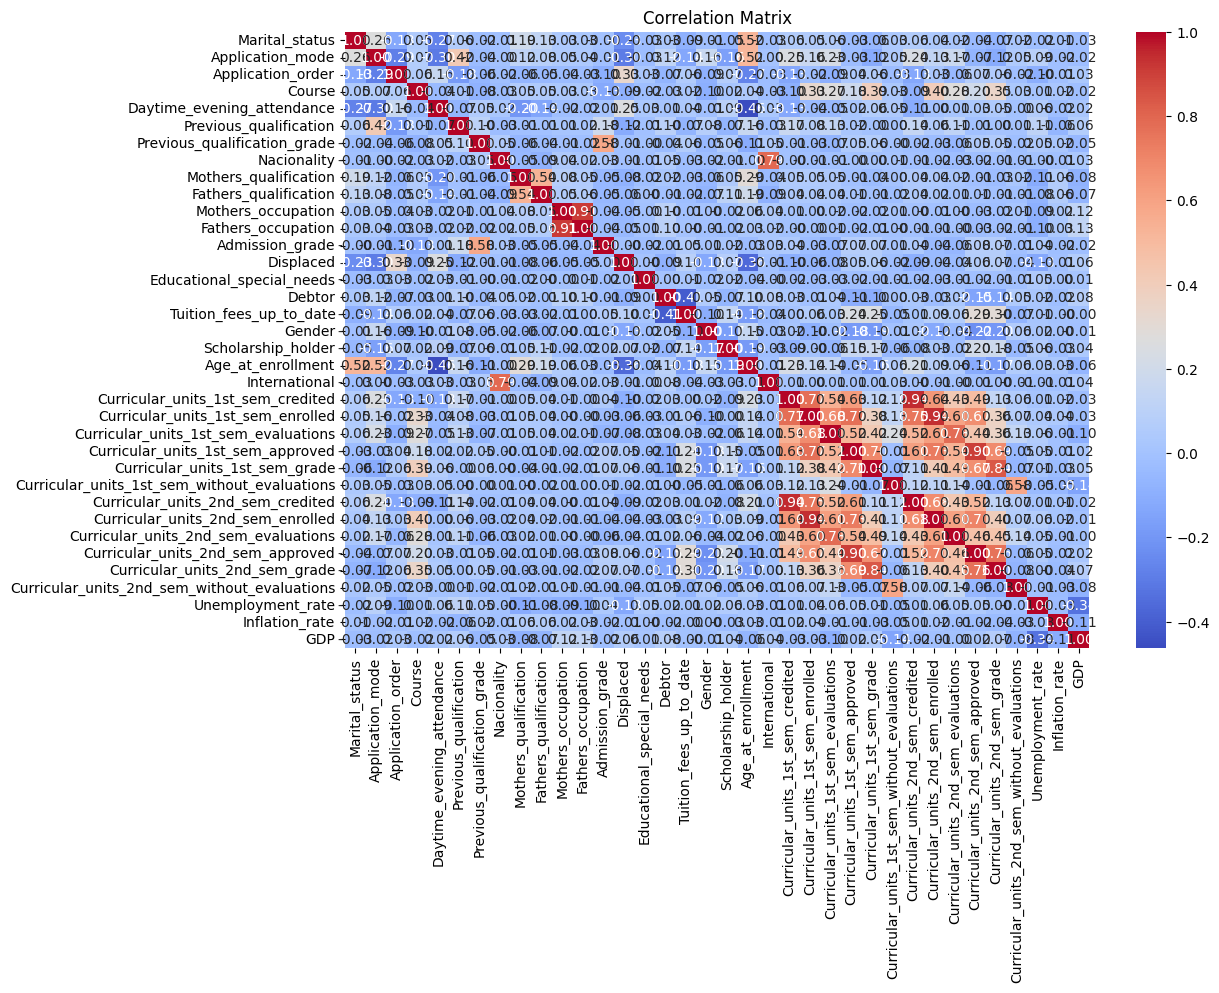

In [4]:
# 3. Exploratory Data Analysis (EDA)
# Melihat distribusi target dan fitur numerik
sns.countplot(data=df, x="Status")
plt.title("Distribusi Status Mahasiswa")
plt.show()

# Korelasi antar fitur numerik
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

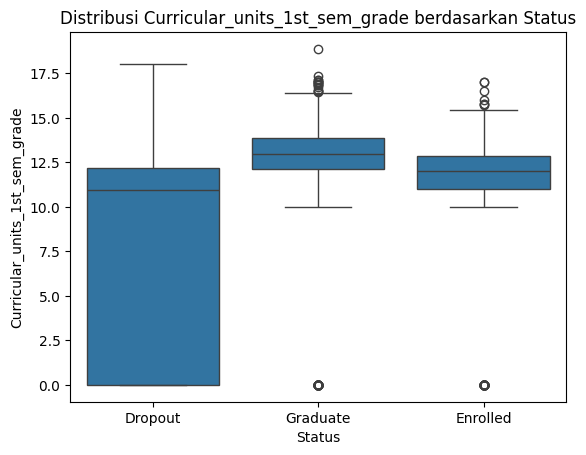

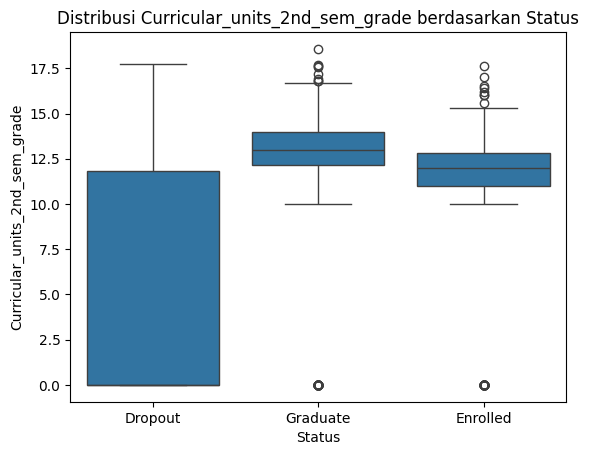

In [5]:
# Boxplot fitur-fitur penting terhadap target
cols = ["Curricular_units_1st_sem_grade", "Curricular_units_2nd_sem_grade"]
for col in cols:
    sns.boxplot(x="Status", y=col, data=df)
    plt.title(f"Distribusi {col} berdasarkan Status")
    plt.show()

# Data Preparation / Preprocessing

**4. Preprocessing dan Encoding**

Fitur diklasifikasikan menjadi dua kategori: numerik dan kategorikal. Kita menggunakan pipeline preprocessing untuk membersihkan dan menyiapkan data:
- Fitur numerik: imputasi nilai hilang dengan mean dan normalisasi (StandardScaler).
- Fitur kategorikal: imputasi dengan modus dan encoding menggunakan OneHotEncoder.
Pipeline disatukan dalam `ColumnTransformer` agar proses preprocessing terintegrasi dan replikatif.


In [6]:
categorical_cols = df.select_dtypes(include=["object"]).columns.drop("Status")
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

In [7]:
# Target encoding
df["Target"] = df["Status"].map({"Dropout": 0, "Graduate": 1, "Enrolled": 2})

In [8]:

# Pipeline preprocessing
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

**5 .Feature Engineering**

Menambahkan fitur baru yang relevan:
- Rasio persetujuan mata kuliah (approved/enrolled) untuk semester 1 dan 2.
- Flag apakah mahasiswa memiliki beasiswa (`has_scholarship`).
Fitur ini dapat meningkatkan prediktivitas model dengan memberikan representasi informasi baru yang lebih kaya.


In [9]:
df["approval_ratio_1st"] = df["Curricular_units_1st_sem_approved"] / df["Curricular_units_1st_sem_enrolled"].replace(0, 1)
df["approval_ratio_2nd"] = df["Curricular_units_2nd_sem_approved"] / df["Curricular_units_2nd_sem_enrolled"].replace(0, 1)
df["has_scholarship"] = df["Scholarship_holder"].apply(lambda x: 1 if x == 1 else 0)

# Update fitur numerik dengan fitur baru
numeric_cols = numeric_cols.tolist() + ["approval_ratio_1st", "approval_ratio_2nd"]

**6. Split Data dan SMOTE**

Dataset dibagi menjadi data latih dan uji menggunakan `train_test_split` dengan stratifikasi agar proporsi kelas tetap seimbang.
Karena terdapat ketidakseimbangan kelas, kita menggunakan SMOTE (Synthetic Minority Over-sampling Technique) untuk menyeimbangkan data latih dengan membuat sampel sintetis dari kelas minoritas.


In [10]:
# 6. Split Data dan SMOTE
X = df.drop(["Status", "Target"], axis=1)
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Resampling dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)


# Modeling

**7. Modeling & Hyperparameter Tuning**

Tiga model digunakan:
- Random Forest
- XGBoost
- CatBoost
Masing-masing model dilakukan hyperparameter tuning menggunakan `GridSearchCV` dengan cross-validation sebanyak 3 fold dan metrik evaluasi `f1_weighted`. Hasil tuning ini memberikan estimator terbaik dari tiap model.


In [11]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {"n_estimators": [100, 200], "max_depth": [10, 20]}
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring="f1_weighted")
rf_grid.fit(X_resampled, y_resampled)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_params = {"n_estimators": [100, 200], "max_depth": [5, 10]}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring="f1_weighted")
xgb_grid.fit(X_resampled, y_resampled)

# CatBoost
cat = CatBoostClassifier(verbose=0, random_state=42)
cat_params = {"depth": [6, 8], "iterations": [100, 200]}
cat_grid = GridSearchCV(cat, cat_params, cv=3, scoring="f1_weighted")
cat_grid.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002338A2872F0>,
             param_grid={'depth': [6, 8], 'iterations': [100, 200]},
             scoring='f1_weighted')

# Evaluation

**8. Evaluation**

Masing-masing model terbaik dievaluasi terhadap data uji menggunakan:
- Classification report (precision, recall, f1-score)
- Confusion matrix
- ROC Curve per kelas (karena target adalah multiclass)
Evaluasi ini memberikan gambaran kinerja model secara menyeluruh pada masing-masing kelas.



Random Forest Evaluation
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       284
           1       0.81      0.90      0.86       442
           2       0.47      0.45      0.46       159

    accuracy                           0.76       885
   macro avg       0.71      0.69      0.69       885
weighted avg       0.76      0.76      0.76       885



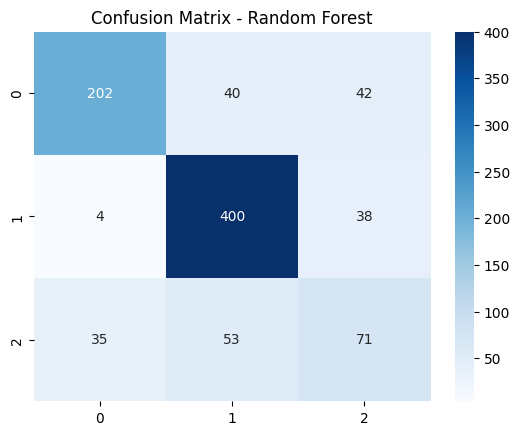

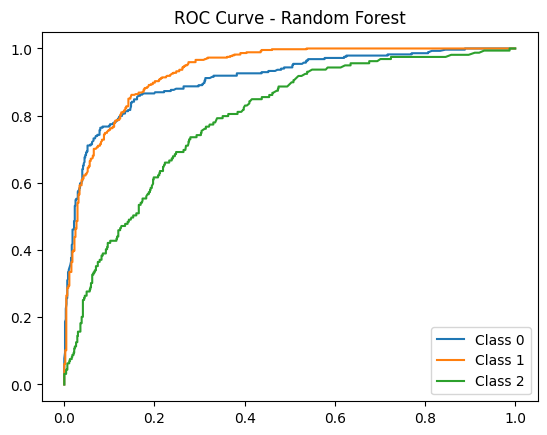


XGBoost Evaluation
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       284
           1       0.81      0.92      0.86       442
           2       0.52      0.42      0.46       159

    accuracy                           0.77       885
   macro avg       0.72      0.69      0.70       885
weighted avg       0.76      0.77      0.76       885



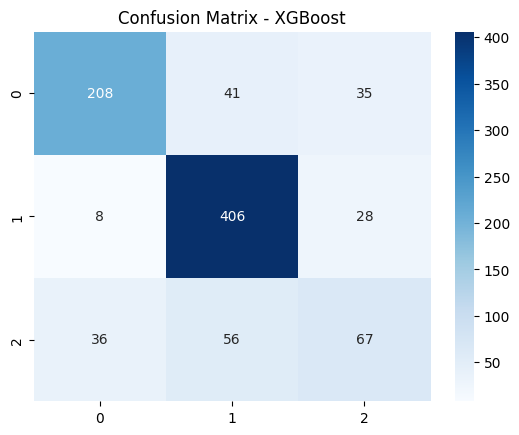

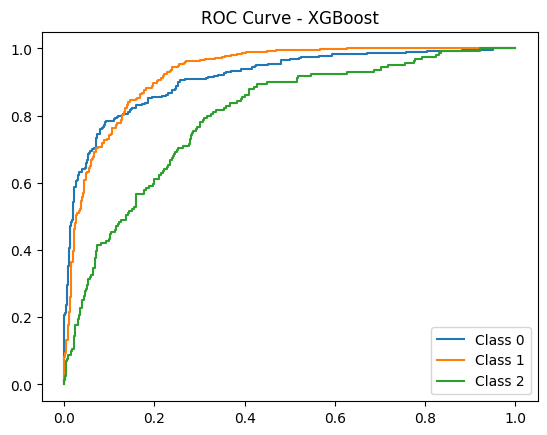


CatBoost Evaluation
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       284
           1       0.82      0.91      0.86       442
           2       0.50      0.45      0.47       159

    accuracy                           0.76       885
   macro avg       0.71      0.69      0.70       885
weighted avg       0.76      0.76      0.76       885



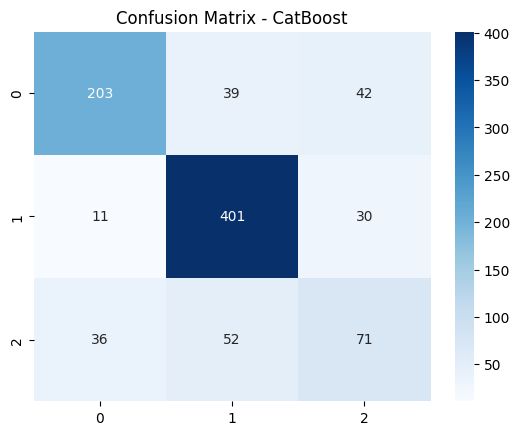

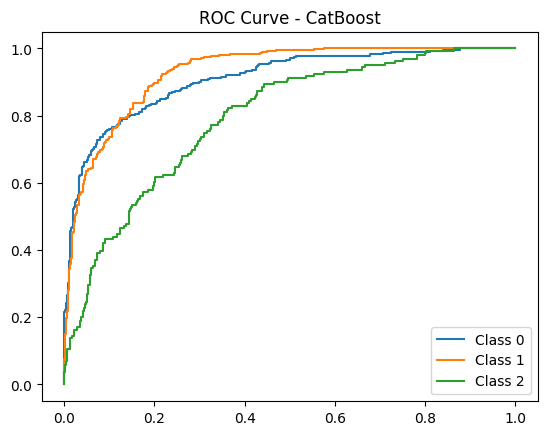

In [12]:
models = {
    "Random Forest": rf_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_,
    "CatBoost": cat_grid.best_estimator_
}

for name, model in models.items():
    print(f"\n{name} Evaluation")
    y_pred = model.predict(X_test_transformed)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_transformed)
        fpr = {}
        tpr = {}
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_proba[:, i])
            plt.plot(fpr[i], tpr[i], label=f"Class {i}")
        plt.title(f"ROC Curve - {name}")
        plt.legend()
        plt.show()

**9. SHAP Analysis (Model Interpretability)**

SHAP (SHapley Additive exPlanations) digunakan untuk menginterpretasikan model XGBoost, yang merupakan salah satu model terbaik.
SHAP summary plot digunakan untuk menunjukkan fitur mana yang paling berkontribusi terhadap prediksi model. Ini penting untuk explainability dan validasi model secara etis dan logis.


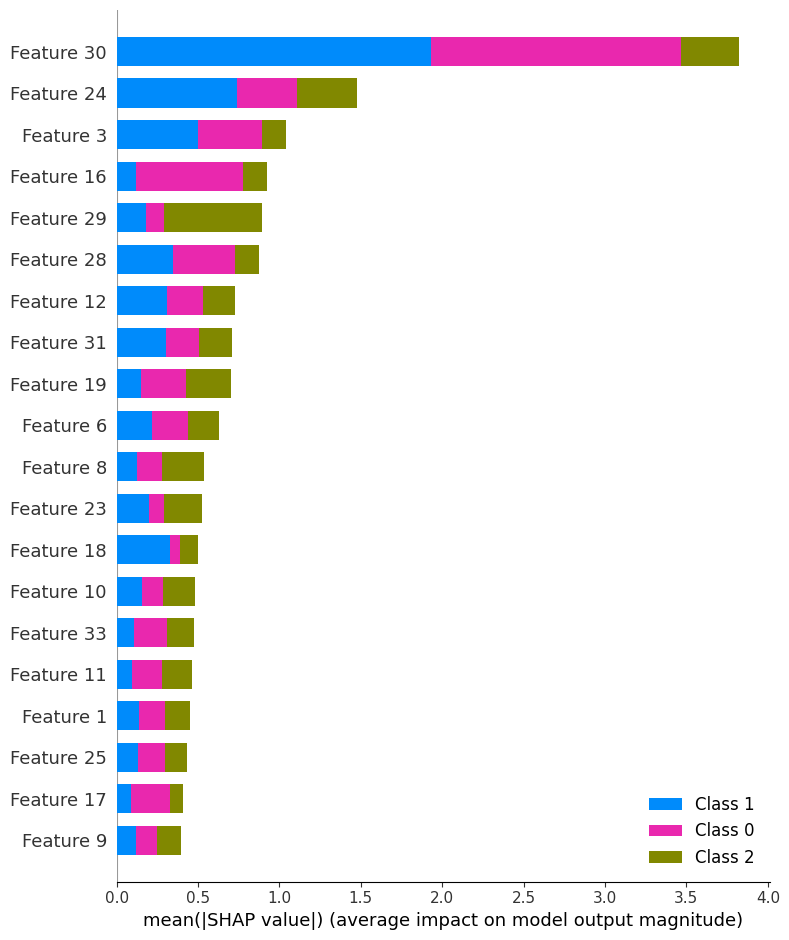

In [13]:
# 9. SHAP Analysis (XGBoost)
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, features=X_test_transformed)


**10. Save Model**

Model terbaik dari eksperimen dapat disimpan menggunakan `pickle` untuk digunakan kembali pada deployment atau inference di masa depan, tanpa perlu melatih ulang model dari awal.


In [16]:
import joblib
import os

# Buat direktori penyimpanan model
os.makedirs("model", exist_ok=True)

import joblib

# Simpan preprocessor dan model terbaik
best_model = xgb_grid.best_estimator_
joblib.dump(preprocessor, "model/preprocessor.pkl")
joblib.dump(best_model, "model/xgboost_model.pkl")
print("Preprocessor dan model berhasil disimpan.")


Preprocessor dan model berhasil disimpan.
